In [1]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

2020-02-13T16:06:38+01:00

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
torch 1.4.0
POLO not installed

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit
host name  : fortytwo
Git hash   : a3b51e82eec9824620662df8f30f3529f076c6e1
Git repo   : https://github.com/bicv/POLO/
Git branch : master


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
width = 32
base_levels = 1.61803
base_levels = 2
n_sublevel = 2
n_azimuth = 18
n_theta = 8
n_phase = 2

N_batch = 1024
minibatch = 64
#N_batch = 128
#N_batch = 16
pattern = 'i05june05_static_street_boston_*.jpeg'

In [4]:
lr = .03
n_epochs = 100
seed = 42
momentum = 0.9
weight_decay = 0.001

# loading an image

In [5]:
%ls ../data/

800px-Fox_Hunt_1893_Winslow_Homer.jpg
homer.jpg
i05june05_static_street_boston_p1010764.jpeg*
i05june05_static_street_boston_p1010764.npy
i05june05_static_street_boston_p1010785.jpeg*
i05june05_static_street_boston_p1010800.jpeg*
i05june05_static_street_boston_p1010806.jpeg*
i05june05_static_street_boston_p1010808.jpeg*


In [6]:
from SLIP import imread

In [7]:
import os

In [8]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

# using torch to build up a Gaussian pyramid

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

In [9]:
img_orig = imread('../data/i05june05_static_street_boston_p1010764.jpeg')
ds = 4
if ds>1: img_orig = img_orig[::ds, ::ds]
img_orig = np.roll(img_orig, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom
from SLIP import Image
pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True, 'do_whitening': True,
       'white_n_learning': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0}

im = Image(pe)
img_orig = im.whitening(img_orig) * im.mask
img_tens = torch.Tensor(img_orig[None, None, ...])
print('Tensor shape=', img_tens.shape)

Tensor shape= torch.Size([1, 1, 192, 256])


In [10]:
from torch.nn.functional import interpolate
from torch.nn.functional import max_pool2d

In [11]:
%%timeit
mode='bilinear'
interpolate(img_tens, scale_factor=1/base_levels, mode=mode)
img_down = max_pool2d(img_down, 2)

NameError: name 'mode' is not defined

In [ ]:
%%timeit
max_pool2d(img_tens, 2)

In [10]:
#from torch.nn.functional import interpolate
from torch.nn.functional import max_pool2d
img_down = img_tens
n_levels = 0
while max(img_down.shape[-2:]) > width :
    n_levels += 1
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels)
    #img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    img_down = max_pool2d(img_down, 2)

n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 192, 256]) , n_levels= 1
Tensor shape= torch.Size([1, 1, 96, 128]) , n_levels= 2
Tensor shape= torch.Size([1, 1, 48, 64]) , n_levels= 3
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 4


In [11]:
def cropped_pyramid(img_tens, n_levels=n_levels, width=width, base_levels=base_levels, verbose=False):
    N_batch = img_tens.shape[0]
    img_crop = torch.zeros((N_batch, n_levels, width, width))

    img_down = img_tens
    for i_level in range(n_levels-1):
        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_tens.shape)
        h_res, w_res = img_down.shape[-2:]

        img_crop[:, i_level, :, :] = img_down[:, 0, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)]
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down[:, 0, :, :]
    return img_crop

Applying on the central crop of $32\times32$:

Tensor shape= torch.Size([1, 4, 32, 32])


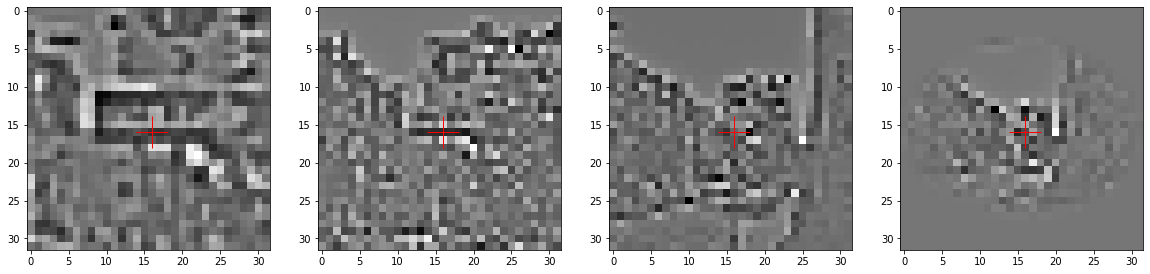

In [12]:
img_tens = torch.Tensor(img_orig[None, None, ...])
img_crop = cropped_pyramid(img_tens)

fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)

## creating a set of filters

In [13]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'do_whitening': True,
      'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N':
          0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0, 'white_recompute': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [14]:
def local_filter(azimuth, theta, phase, sf_0=.25, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2 # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=lg.pe.B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.4102999708906189 1.0


In [15]:

K = np.zeros((width, width, n_sublevel, n_azimuth, n_theta, n_phase))
for i_sublevel in range(n_sublevel):
    sf_0 = .25*(np.sqrt(2)**i_sublevel)
    radius = width/4/(np.sqrt(2)**i_sublevel)
    print('i_sublevel, sf_0, radius', i_sublevel, sf_0, radius)
    for i_azimuth in range(n_azimuth):
        for i_theta in range(n_theta):
            for i_phase in range(n_phase):
                K[..., i_sublevel, i_azimuth, i_theta, i_phase] = local_filter(azimuth=(i_azimuth+i_sublevel/2)*2*np.pi/n_azimuth, 
                                                                               theta=i_theta*np.pi/n_theta, 
                                                                               phase=i_phase*np.pi/n_phase, sf_0=sf_0, radius=radius)
K = torch.Tensor(K)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

i_sublevel, sf_0, radius 0 0.25 8.0
i_sublevel, sf_0, radius 1 0.3535533905932738 5.65685424949238
K shape= torch.Size([32, 32, 2, 18, 8, 2])
K min max= tensor(-1.) tensor(1.)


# defining a dataloader


In [16]:
def get_dataloader(N_batch, pattern=pattern, 
                   ds=4, saccade_radius=.4, verbose=False):
    from glob import glob
    imgs = []
    for fname in glob(os.path.join('../data', pattern)):
        img_orig = imread(fname)
        if ds>1: img_orig = img_orig[::ds, ::ds]
        from SLIP import Image
        pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True, 'do_whitening': True,
               'white_n_learning': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
              'white_steepness': 4.0}
        im = Image(pe)
        img_orig = im.whitening(img_orig) * im.mask
        imgs.append(img_orig)
                          
    N_imgs = len(imgs)
    if verbose: print('N_imgs ', N_imgs )
    N_X, N_Y = img_orig.shape
    target = torch.zeros((N_batch, 1, N_X, N_Y))
    for i in range(N_batch):
        # generate random saccades
        target_ = imgs[int(N_imgs*np.random.rand())].copy()
        sacc_x, sacc_y = np.int(saccade_radius*N_X*np.random.randn()), np.int(saccade_radius*N_Y*np.random.randn())
        if verbose: print('sacc_x, sacc_y ', sacc_x, sacc_y )
        target_ = np.roll(target_, sacc_y, axis=1)
        target_ = np.roll(target_, sacc_x, axis=0) 
        target_ = im.whitening(target_) * im.mask
        target[i, :, :, :] = torch.from_numpy(target_[None, :, :])

    print(target.shape)
    img_crop = cropped_pyramid(target, verbose=verbose)
    print(img_crop.shape)
    x = torch.tensordot(img_crop, K,  dims=2)

    from torch.utils.data import TensorDataset, DataLoader
    dataloader = DataLoader(TensorDataset(target, x), batch_size=minibatch, shuffle=False, drop_last=False)
    return dataloader

dataloader = get_dataloader(N_batch, verbose=False)

torch.Size([1024, 1, 192, 256])
torch.Size([1024, 4, 32, 32])


In [17]:
from torch.utils.data import TensorDataset, DataLoader
DataLoader?

Init signature:
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional automatic batching (collation) and memory pinning.

See :py:mod:`torch.utils.data` documentation page for more details.

Arguments:
    dataset (Dataset): dataset from which to load the data.
    batch_size (int, optional): how many samples per batch to load
        (default: ``1``).
    shuffle (bool, optional): set to ``True`` to have the data reshuffled
        at every epoch (default: ``False``).
    sampler (Sampler, optional):

In [18]:
for batch_idx, (target, x) in enumerate(dataloader):
    print(batch_idx, target.shape, x.shape)

0 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
1 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
2 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
3 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
4 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
5 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
6 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
7 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
8 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
9 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
10 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
11 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
12 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
13 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
14 torch.Size([64, 1, 192, 256]) torch.Size([64, 4, 2, 18, 8, 2])
15 torch.Size([64, 1

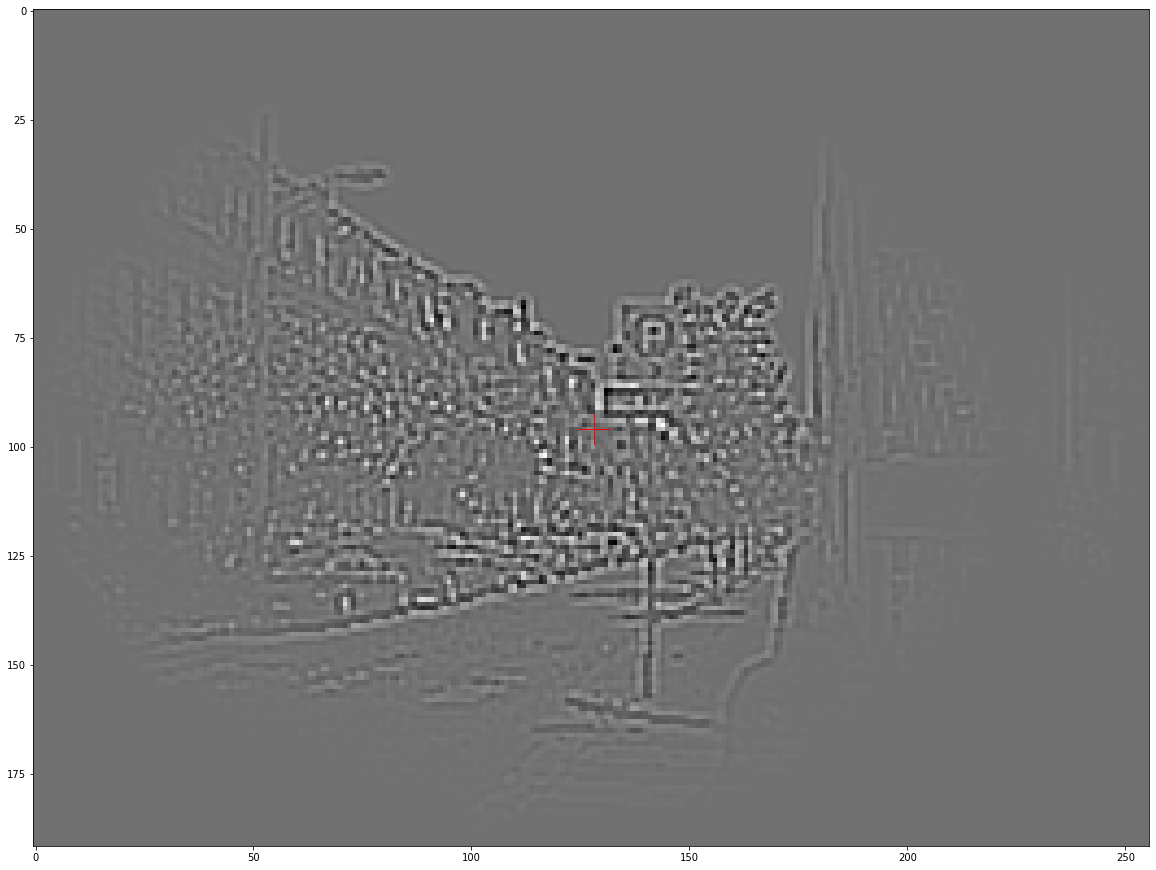

In [19]:
N_X, N_Y = target.shape[-2:]
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(target[0, 0, :,:].numpy(), cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);


## learning to reconstruct



In [20]:
n_levels

4

In [21]:
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu" # uncomment to force CPU mode
print(f'using {device}')

using cpu


In [22]:
class Invert(torch.nn.Module):
    def __init__(self, n_in, n_out, verbose=False):
        super(Invert, self).__init__()
        if verbose: print('n_in, n_out=', n_in, n_out)
        self.KT = torch.nn.Linear(n_in, n_out, bias=False)
        
    def forward(self, x):
        return self.KT(x)

In [ ]:
criterion = torch.nn.MSELoss(reduction='mean') 
n_in, n_out = n_levels*n_sublevel*n_azimuth*n_theta*n_phase, np.prod(img_orig.shape)


def learn(n_epochs=n_epochs, momentum=momentum, 
          lr=lr, weight_decay=weight_decay, verbose=False):
    import time
    invert = Invert(n_in=n_in, n_out=n_out, verbose=verbose)

    # set a relative precision required proportional to the mask
    mask_ = im.mask.ravel()
    mask_im = torch.from_numpy(mask_[None, None, :])

    def init_weights(m):
        if verbose: print(m)
        if type(m) == torch.nn.Linear:
            m.weight.data = K.std() * torch.randn_like(m.weight.data)
            m.weight.data *= torch.from_numpy(mask_[:, None]) * torch.ones((1, n_in))
    invert.KT.apply(init_weights)

    invert = invert.to(device)

    # optimizer = torch.optim.SGD(invert.parameters(), 
    #                            lr=lr, momentum=momentum, 
    #                            weight_decay=weight_decay)
    # https://pytorch.org/docs/stable/optim.html#torch.optim.Adam
    optimizer = torch.optim.Adam(invert.parameters(), lr=lr, 
                                 betas=(momentum, 0.999), eps=1e-08, 
                                 weight_decay=weight_decay)

    # ----------
    #  Training
    # ----------
    loss_0 = None
    invert.train()
    for epoch in range(n_epochs):
        t_batch = time.time()
        for batch_idx, (target, x) in enumerate(dataloader):
            #print(target.shape, x.shape)
            target = target.squeeze(1)
            #print(target.shape, x.shape)
            target = target.reshape((target.shape[0], n_out))
            x = x.reshape((target.shape[0], n_in))
            #print(target.shape, x.shape)

            target, x = target.to(device), x.to(device)

            optimizer.zero_grad()
            im_rec = invert(x)
            if loss_0 is None:
                loss_0 = criterion(target, torch.zeros_like(target))
            loss = criterion(target, im_rec) / loss_0
            #loss = criterion(target*mask_im, im_rec*mask_im) / loss_0
            loss.backward()
            optimizer.step()

        if verbose: print("[Epoch %d/%d][loss: %f] [Time: %fs]" % (epoch+1, n_epochs, loss.item(), time.time()-t_batch))

    invert.eval()
    return invert, loss.item()
invert, loss = learn(verbose=True)


n_in, n_out= 2304 49152
Linear(in_features=2304, out_features=49152, bias=False)
[Epoch 1/100][loss: 278.306140] [Time: 38.547565s]
[Epoch 2/100][loss: 411.115605] [Time: 38.252820s]
[Epoch 3/100][loss: 634.037609] [Time: 38.025978s]
[Epoch 4/100][loss: 816.794580] [Time: 38.203477s]
[Epoch 5/100][loss: 865.911459] [Time: 37.905870s]
[Epoch 6/100][loss: 788.323670] [Time: 37.820298s]
[Epoch 7/100][loss: 674.116984] [Time: 37.570907s]
[Epoch 8/100][loss: 587.580550] [Time: 37.794574s]
[Epoch 9/100][loss: 533.259077] [Time: 38.048018s]
[Epoch 10/100][loss: 497.783453] [Time: 37.940568s]
[Epoch 11/100][loss: 471.048748] [Time: 37.874555s]
[Epoch 12/100][loss: 448.158159] [Time: 38.549875s]
[Epoch 13/100][loss: 430.397129] [Time: 38.236643s]
[Epoch 14/100][loss: 418.225949] [Time: 38.284111s]
[Epoch 15/100][loss: 410.499272] [Time: 38.110310s]
[Epoch 16/100][loss: 405.167465] [Time: 38.098321s]
[Epoch 17/100][loss: 401.318503] [Time: 38.230857s]
[Epoch 18/100][loss: 399.758047] [Time: 38.1

In [ ]:
print(K.std(), invert.KT.weight.data.std())

## reconstructing one image

In [ ]:
for batch_idx, (target, x) in enumerate(dataloader):
    print(batch_idx, target.shape, x.shape)

In [ ]:
i_target = 0
img_tens = target[i_target, :].reshape(img_orig.shape)
x_target = x[i_target, :]
#print('x_target.shape', x_target.shape)
# x_target = torch.tensordot(cropped_pyramid(target[i_target, :].reshape(img_orig.shape)[None, None, ...]), K, dims=2)
x_target = x_target.reshape((1, n_levels*n_sublevel*n_azimuth*n_theta*n_phase))
#print('x_target.shape', x_target.shape)
im_rec = invert(x_target).reshape(img_tens.shape)
#print('im_rec.shape', im_rec.shape)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens, im_rec.detach()]):
    ax.imshow(img.numpy(), cmap='gray')
    ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

## validating on the test set

In [ ]:
test_dataloader = get_dataloader(1, verbose=False)
for batch_idx, (target, x) in enumerate(test_dataloader):
    print(batch_idx, target.shape, x.shape)

In [ ]:
i_target = 0
img_tens = target[i_target, :].reshape(img_orig.shape)
x_target = x[i_target, :].reshape((1, n_levels*n_sublevel*n_azimuth*n_theta*n_phase))
im_rec = invert(x_target).reshape(img_tens.shape)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens, im_rec.detach()]):
    ax.imshow(img.numpy(), cmap='gray')
    ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

## testing different parameters

In [ ]:
test_dataloader = get_dataloader(20, verbose=False)
for batch_idx, (target, x) in enumerate(test_dataloader):
    print(batch_idx, target.shape, x.shape)
loss_0 = criterion(target, torch.zeros_like(target))
N_test = 5

In [ ]:
weight_decay_0 = .0001

for weight_decay_ in weight_decay_0*np.logspace(-1, 1, N_test, endpoint=True, base=4):
    invert, loss = learn(n_epochs=n_epochs//4, momentum=momentum, lr=lr, weight_decay=weight_decay_, verbose=False)
    invert.eval()
    target = target.squeeze(1)
    target = target.reshape((target.shape[0], n_out))
    x = x.reshape((target.shape[0], n_in))
    im_rec = invert(x)
    test_loss = criterion(target, im_rec) / loss_0
    print('weight_decay_ =', weight_decay_, '/ loss =', loss, '/ test_loss =', test_loss)

In [ ]:
weight_decay_0 = weight_decay
N_test = 5
for weight_decay_ in weight_decay_0*np.logspace(-1, 1, N_test, endpoint=True, base=4):
    invert, loss = learn(n_epochs=n_epochs//4, momentum=momentum, lr=lr, weight_decay=weight_decay_, verbose=False)
    invert.eval()
    target = target.squeeze(1)
    target = target.reshape((target.shape[0], n_out))
    x = x.reshape((target.shape[0], n_in))
    im_rec = invert(x)
    test_loss = criterion(target, im_rec) / loss_0
    print('weight_decay_ =', weight_decay_, '/ loss =', loss, '/ test_loss =', test_loss)

In [ ]:
for lr_ in lr*np.logspace(-1, 1, N_test, endpoint=True, base=4):
    invert, loss = learn(n_epochs=n_epochs//4, momentum=momentum, lr=lr_, weight_decay=weight_decay, verbose=False)
    invert.eval()
    target = target.squeeze(1)
    target = target.reshape((target.shape[0], n_out))
    x = x.reshape((target.shape[0], n_in))
    im_rec = invert(x)
    test_loss = criterion(target, im_rec) / loss_0
    print('weight_decay_ =', weight_decay_, '/ loss =', loss, '/ test_loss =', test_loss)

In [ ]:
for momentum_ in np.linspace(0.5, 1, N_test, endpoint=True):
    invert, loss = learn(n_epochs=n_epochs//4, momentum=momentum_, lr=lr, weight_decay=weight_decay, verbose=False)
    invert.eval()
    target = target.squeeze(1)
    target = target.reshape((target.shape[0], n_out))
    x = x.reshape((target.shape[0], n_in))
    im_rec = invert(x)
    test_loss = criterion(target, im_rec) / loss_0
    print('weight_decay_ =', weight_decay_, '/ loss =', loss, '/ test_loss =', test_loss)